In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [ ]:
from utilities.userfold_framework import *
from utilities.EEG_func import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
# import Models.model_func as Model_Func
from torch import nn
from Models.multi_models import *

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

for i in range(len(participants)):

    train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                      raw_user_fold,
                                                                                      participants,
                                                                                      batch_size=batch_size,
                                                                                      transpose_channels=transpose_channels)

    classifier= EEGNet(
        chunk_size=input_dim[1],
        num_electrodes=input_dim[0],
        num_classes=classes,
        kernel_1= 32,
        kernel_2=32,
        F1=8,
        F2=16,
        dropout=0.5
    ).to(DEVICE)
    
#     resnet = ResNetPlus(input_dim[0], classes, bn_1st=False)
#     softmax_activation = nn.LogSoftmax(dim=1)
#     classifier = nn.Sequential(resnet, softmax_activation).to(DEVICE)

    
#     classifier = DataGliderBasic_Model(DEVICE, input_dim, classes)
#     classifier.to(DEVICE)
    
#     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)
    
    
    criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
#     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
        
    saved_dir= "./EEG/saved_models/Userfold/run2"
    model = EEGNet_DF_HP_Wrapper(DEVICE, classifier, input_dim).to(DEVICE)
#     model= EEGNet_Wrapper(DEVICE, df)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

    
    train_func= eeg_DF_train
    model.training_procedure(iteration=n_epochs,
                                    train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader,
                                     print_cycle=2,
                                     path=f"./dictionary/intermdiate_dicts",
                                     loss_func=criterion,
                                     optimiser=optimizer, #scheduler=scheduler,
                                     train_func=train_func
                                    )
    if model.epoch == n_epochs+1:
        EPOCH= n_epochs
    else:
        EPOCH= model.epoch
    
    torch.save(model.state_dict(), 
           os.path.join(
               saved_dir, f"Userfold-{participants[i]}-EEGNet-DF_Multivariate-e{EPOCH}.pt"
           )
    )

    pickle.dump( model.return_DF_weights(), 
                open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-DF_Multivariate-w-e{EPOCH}.pkl", "wb") 
               )    

# OR
#     model.load_state_dict(
#     torch.load(
#         open(
#             os.path.join(
#                 saved_dir, f"Userfold-{participants[i]}-EEGNet-DF_Multivariate-e{n_epochs}.pt"
#             ), "rb"
#         )
#               )
#     )

    
    prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)
    
    ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])
    
    c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
    print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
    b_acc_list.append(b_acc)
    c0_acc_list.append(c0_acc)
    c1_acc_list.append(c1_acc)
    participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3204.002154181985


Iterations:   0%|                                   | 1/300 [00:03<15:49,  3.18s/it]

Epoch:  0
t_loss:  3204.002154181985 , v_loss:  0.6909792820612589
t_acc:  0.6131341425459073 , v_acc:  0.6024844720496895
t_recall:  0.48787142641468 , v_recall:  0.5743243243243243
t_prec:  0.48293642109599266 , v_prec:  0.5664465206185567
t_f:  0.4763797485448471 , v_f:  0.5654520917678812
////////


Iterations:   1%|▏                                  | 2/300 [00:03<08:36,  1.73s/it]

Epoch  1 , loss 3187.145325903799
Epoch  2 , loss 3170.3408011642155


Iterations:   1%|▎                                  | 3/300 [00:05<07:19,  1.48s/it]

Epoch:  2
t_loss:  3170.3408011642155 , v_loss:  0.6837844451268514
t_acc:  0.6591970121381886 , v_acc:  0.6645962732919255
t_recall:  0.5011412140925873 , v_recall:  0.5699099099099099
t_prec:  0.5027960795478748 , v_prec:  0.5862222222222222
t_f:  0.4674331705818108 , v_f:  0.57163973196689
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:48,  1.18s/it]

Epoch  3 , loss 3153.58784754136
Epoch  4 , loss 3136.870423560049


Iterations:   2%|▌                                  | 5/300 [00:07<05:51,  1.19s/it]

Epoch:  4
t_loss:  3136.870423560049 , v_loss:  0.6665934125582377
t_acc:  0.6809835045129162 , v_acc:  0.7142857142857143
t_recall:  0.5035746146772622 , v_recall:  0.5564864864864865
t_prec:  0.5175639527042215 , v_prec:  0.707615894039735
t_f:  0.44698971616563415 , v_f:  0.528880407124682
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:05,  1.04s/it]

Epoch  5 , loss 3120.194972617953
Epoch  6 , loss 3103.5769856770835


Iterations:   2%|▊                                  | 7/300 [00:08<05:19,  1.09s/it]

Epoch:  6
t_loss:  3103.5769856770835 , v_loss:  0.6476051807403564
t_acc:  0.6850295673825085 , v_acc:  0.7080745341614907
t_recall:  0.499007013354195 , v_recall:  0.53
t_prec:  0.4913401691669326 , v_prec:  0.8512658227848101
t_f:  0.42747683535281533 , v_f:  0.4692431787893666
////////


Iterations:   3%|▉                                  | 8/300 [00:09<04:48,  1.01it/s]

Epoch  7 , loss 3087.0069891237745
Epoch  8 , loss 3070.471248851103


Iterations:   3%|█                                  | 9/300 [00:10<05:03,  1.04s/it]

Epoch:  8
t_loss:  3070.471248851103 , v_loss:  0.6373981138070425
t_acc:  0.6956115779645191 , v_acc:  0.6956521739130435
t_recall:  0.509201081511371 , v_recall:  0.51
t_prec:  0.5997935852651635 , v_prec:  0.846875
t_f:  0.43988550706864443 , v_f:  0.42920193907821425
////////


Iterations:   3%|█▏                                | 10/300 [00:11<04:35,  1.05it/s]

Epoch  9 , loss 3053.9991335401346
Epoch  10 , loss 3037.5693550857845


Iterations:   4%|█▏                                | 11/300 [00:12<04:53,  1.02s/it]

Epoch:  10
t_loss:  3037.5693550857845 , v_loss:  0.6342689692974091
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.5045044674105488 , v_recall:  0.5
t_prec:  0.5795404973098734 , v_prec:  0.3447204968944099
t_f:  0.4270169187048135 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:13<04:25,  1.09it/s]

Epoch  11 , loss 3021.174211090686
Epoch  12 , loss 3004.832088694853


Iterations:   4%|█▍                                | 13/300 [00:14<04:45,  1.00it/s]

Epoch:  12
t_loss:  3004.832088694853 , v_loss:  0.6340790589650472
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5044729004542897 , v_recall:  0.5
t_prec:  0.6179913591272236 , v_prec:  0.3447204968944099
t_f:  0.42394053443180435 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:15<04:20,  1.10it/s]

Epoch  13 , loss 2988.5285883884803
Epoch  14 , loss 2972.2772575827207


Iterations:   5%|█▋                                | 15/300 [00:16<04:41,  1.01it/s]

Epoch:  14
t_loss:  2972.2772575827207 , v_loss:  0.6337993840376536
t_acc:  0.6937441643323996 , v_acc:  0.6894409937888198
t_recall:  0.5006704547014178 , v_recall:  0.5
t_prec:  0.5229486376448481 , v_prec:  0.3447204968944099
t_f:  0.4163729079382051 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:18,  1.10it/s]

Epoch  15 , loss 2956.067234413297
Epoch  16 , loss 2939.925963158701


Iterations:   6%|█▉                                | 17/300 [00:18<04:38,  1.02it/s]

Epoch:  16
t_loss:  2939.925963158701 , v_loss:  0.6336913406848907
t_acc:  0.6962340491752257 , v_acc:  0.6956521739130435
t_recall:  0.5036102990625986 , v_recall:  0.51
t_prec:  0.6235750078296274 , v_prec:  0.846875
t_f:  0.42111784364602456 , v_f:  0.42920193907821425
////////


Iterations:   6%|██                                | 18/300 [00:19<04:14,  1.11it/s]

Epoch  17 , loss 2923.842084099265
Epoch  18 , loss 2907.8108388863357


Iterations:   6%|██▏                               | 19/300 [00:20<04:38,  1.01it/s]

Epoch:  18
t_loss:  2907.8108388863357 , v_loss:  0.6331145465373993
t_acc:  0.6949891067538126 , v_acc:  0.6956521739130435
t_recall:  0.5027154444764689 , v_recall:  0.51
t_prec:  0.5775517403574788 , v_prec:  0.846875
t_f:  0.4206388108738276 , v_f:  0.42920193907821425
////////


Iterations:   7%|██▎                               | 20/300 [00:21<04:14,  1.10it/s]

Epoch  19 , loss 2891.823931525735
Epoch  20 , loss 2875.8985380284926


Iterations:   7%|██▍                               | 21/300 [00:22<04:33,  1.02it/s]

Epoch:  20
t_loss:  2875.8985380284926 , v_loss:  0.6324409047762553
t_acc:  0.6977902272019919 , v_acc:  0.6956521739130435
t_recall:  0.5055914686869519 , v_recall:  0.51
t_prec:  0.6823308270676691 , v_prec:  0.846875
t_f:  0.42455390714097185 , v_f:  0.42920193907821425
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:11,  1.11it/s]

Epoch  21 , loss 2860.029114966299
Epoch  22 , loss 2844.227845435049


Iterations:   8%|██▌                               | 23/300 [00:24<04:33,  1.01it/s]

Epoch:  22
t_loss:  2844.227845435049 , v_loss:  0.6304201086362203
t_acc:  0.6943666355431062 , v_acc:  0.6956521739130435
t_recall:  0.5002552806027916 , v_recall:  0.51
t_prec:  0.514526710402999 , v_prec:  0.846875
t_f:  0.4137166365643187 , v_f:  0.42920193907821425
////////


Iterations:   8%|██▋                               | 24/300 [00:24<04:13,  1.09it/s]

Epoch  23 , loss 2828.4853276271447
Epoch  24 , loss 2812.796980315564


Iterations:   8%|██▊                               | 25/300 [00:26<04:33,  1.01it/s]

Epoch:  24
t_loss:  2812.796980315564 , v_loss:  0.6279860039552053
t_acc:  0.6968565203859322 , v_acc:  0.6956521739130435
t_recall:  0.5034826587612028 , v_recall:  0.51
t_prec:  0.6699749921850578 , v_prec:  0.846875
t_f:  0.4194516752347822 , v_f:  0.42920193907821425
////////


Iterations:   9%|██▉                               | 26/300 [00:26<04:09,  1.10it/s]

Epoch  25 , loss 2797.1474130667893
Epoch  26 , loss 2781.530642041973


Iterations:   9%|███                               | 27/300 [00:27<04:33,  1.00s/it]

Epoch:  26
t_loss:  2781.530642041973 , v_loss:  0.6254345178604126
t_acc:  0.6965452847805789 , v_acc:  0.7018633540372671
t_recall:  0.5026838775202097 , v_recall:  0.52
t_prec:  0.6665578331724491 , v_prec:  0.8490566037735849
t_f:  0.4174144390948958 , v_f:  0.44957264957264953
////////


Iterations:   9%|███▏                              | 28/300 [00:28<04:09,  1.09it/s]

Epoch  27 , loss 2765.967486213235
Epoch  28 , loss 2750.456169577206


Iterations:  10%|███▎                              | 29/300 [00:29<04:27,  1.01it/s]

Epoch:  28
t_loss:  2750.456169577206 , v_loss:  0.6230132083098093
t_acc:  0.6962340491752257 , v_acc:  0.7018633540372671
t_recall:  0.503035231468138 , v_recall:  0.52
t_prec:  0.6297016734438536 , v_prec:  0.8490566037735849
t_f:  0.4192163289012425 , v_f:  0.44957264957264953
////////


Iterations:  10%|███▍                              | 30/300 [00:30<04:05,  1.10it/s]

Epoch  29 , loss 2735.0083247166053
Epoch  30 , loss 2719.6152678844974


Iterations:  10%|███▌                              | 31/300 [00:31<04:24,  1.02it/s]

Epoch:  30
t_loss:  2719.6152678844974 , v_loss:  0.6203732987244924
t_acc:  0.6981014628073452 , v_acc:  0.7018633540372671
t_recall:  0.5049525809417933 , v_recall:  0.52
t_prec:  0.7417161613004064 , v_prec:  0.8490566037735849
t_f:  0.4218358572666722 , v_f:  0.44957264957264953
////////


Iterations:  11%|███▋                              | 32/300 [00:32<04:03,  1.10it/s]

Epoch  31 , loss 2704.2819058287378
Epoch  32 , loss 2688.9963570389095


Iterations:  11%|███▋                              | 33/300 [00:33<04:21,  1.02it/s]

Epoch:  32
t_loss:  2688.9963570389095 , v_loss:  0.617683619260788
t_acc:  0.6965452847805789 , v_acc:  0.7018633540372671
t_recall:  0.50297141131744 , v_recall:  0.52
t_prec:  0.6561298076923077 , v_prec:  0.8490566037735849
t_f:  0.4183762417414505 , v_f:  0.44957264957264953
////////


Iterations:  11%|███▊                              | 34/300 [00:34<03:58,  1.12it/s]

Epoch  33 , loss 2673.7688802083335
Epoch  34 , loss 2658.5848747702207


Iterations:  12%|███▉                              | 35/300 [00:35<04:19,  1.02it/s]

Epoch:  34
t_loss:  2658.5848747702207 , v_loss:  0.6139567891756693
t_acc:  0.6984126984126984 , v_acc:  0.7080745341614907
t_recall:  0.5069014973717078 , v_recall:  0.53
t_prec:  0.6892785445420326 , v_prec:  0.8512658227848101
t_f:  0.42760745975240416 , v_f:  0.4692431787893666
////////


Iterations:  12%|████                              | 36/300 [00:36<03:56,  1.12it/s]

Epoch  35 , loss 2643.4482086780026
Epoch  36 , loss 2628.401549096201


Iterations:  12%|████▏                             | 37/300 [00:37<04:17,  1.02it/s]

Epoch:  36
t_loss:  2628.401549096201 , v_loss:  0.6100755532582601
t_acc:  0.6968565203859322 , v_acc:  0.7080745341614907
t_recall:  0.5049203277473546 , v_recall:  0.53
t_prec:  0.64052210724365 , v_prec:  0.8512658227848101
t_f:  0.42418592019500817 , v_f:  0.4692431787893666
////////


Iterations:  13%|████▎                             | 38/300 [00:38<03:56,  1.11it/s]

Epoch  37 , loss 2613.3855363434436
Epoch  38 , loss 2598.416187959559


Iterations:  13%|████▍                             | 39/300 [00:39<04:15,  1.02it/s]

Epoch:  38
t_loss:  2598.416187959559 , v_loss:  0.6085506975650787
t_acc:  0.7005913476501712 , v_acc:  0.7142857142857143
t_recall:  0.5096176280863562 , v_recall:  0.54
t_prec:  0.7537049552267625 , v_prec:  0.8535031847133758
t_f:  0.4322036825034792 , v_f:  0.488253178551686
////////


Iterations:  13%|████▌                             | 40/300 [00:39<03:57,  1.10it/s]

Epoch  39 , loss 2583.505801930147
Epoch  40 , loss 2568.6325204886643


Iterations:  14%|████▋                             | 41/300 [00:41<04:17,  1.00it/s]

Epoch:  40
t_loss:  2568.6325204886643 , v_loss:  0.6061117649078369
t_acc:  0.6959228135698724 , v_acc:  0.7142857142857143
t_recall:  0.5033865854160662 , v_recall:  0.54
t_prec:  0.6104323308270676 , v_prec:  0.8535031847133758
t_f:  0.4209981125404011 , v_f:  0.488253178551686
////////


Iterations:  14%|████▊                             | 42/300 [00:41<03:54,  1.10it/s]

Epoch  41 , loss 2553.8041848575367
Epoch  42 , loss 2539.0115081188724


Iterations:  14%|████▊                             | 43/300 [00:43<04:15,  1.01it/s]

Epoch:  42
t_loss:  2539.0115081188724 , v_loss:  0.6036013315121332
t_acc:  0.6996576408341114 , v_acc:  0.7142857142857143
t_recall:  0.5077963519578376 , v_recall:  0.54
t_prec:  0.7542293233082706 , v_prec:  0.8535031847133758
t_f:  0.42810970174154256 , v_f:  0.488253178551686
////////


Iterations:  15%|████▉                             | 44/300 [00:43<03:52,  1.10it/s]

Epoch  43 , loss 2524.2747443704043
Epoch  44 , loss 2509.588747510723


Iterations:  15%|█████                             | 45/300 [00:44<04:12,  1.01it/s]

Epoch:  44
t_loss:  2509.588747510723 , v_loss:  0.6002827485402426
t_acc:  0.6996576408341114 , v_acc:  0.7142857142857143
t_recall:  0.50980908853845 , v_recall:  0.54
t_prec:  0.6927627438640654 , v_prec:  0.8535031847133758
t_f:  0.4345547418019834 , v_f:  0.488253178551686
////////


Iterations:  15%|█████▏                            | 46/300 [00:45<03:51,  1.10it/s]

Epoch  45 , loss 2494.9344027650122
Epoch  46 , loss 2480.338503370098


Iterations:  16%|█████▎                            | 47/300 [00:46<04:12,  1.00it/s]

Epoch:  46
t_loss:  2480.338503370098 , v_loss:  0.5966360419988632
t_acc:  0.6956115779645191 , v_acc:  0.7267080745341615
t_recall:  0.5040254731612248 , v_recall:  0.56
t_prec:  0.5986656200941916 , v_prec:  0.8580645161290323
t_f:  0.42369509878001366 , v_f:  0.5244360902255639
////////


Iterations:  16%|█████▍                            | 48/300 [00:47<03:53,  1.08it/s]

Epoch  47 , loss 2465.789244408701
Epoch  48 , loss 2451.281556372549


Iterations:  16%|█████▌                            | 49/300 [00:48<04:12,  1.01s/it]

Epoch:  48
t_loss:  2451.281556372549 , v_loss:  0.5946276982625326
t_acc:  0.6993464052287581 , v_acc:  0.7267080745341615
t_recall:  0.5090103072974568 , v_recall:  0.56
t_prec:  0.6934827884313108 , v_prec:  0.8580645161290323
t_f:  0.4326019714231394 , v_f:  0.5244360902255639
////////


Iterations:  17%|█████▋                            | 50/300 [00:49<03:50,  1.08it/s]

Epoch  49 , loss 2436.8341902190564
Epoch  50 , loss 2422.4239621629904


Iterations:  17%|█████▊                            | 51/300 [00:50<04:09,  1.00s/it]

Epoch:  50
t_loss:  2422.4239621629904 , v_loss:  0.5931285818417867
t_acc:  0.6981014628073452 , v_acc:  0.7329192546583851
t_recall:  0.5069653175224057 , v_recall:  0.5700000000000001
t_prec:  0.6707221350078494 , v_prec:  0.8603896103896104
t_f:  0.4284092493012405 , v_f:  0.5416749420721615
////////


Iterations:  17%|█████▉                            | 52/300 [00:51<03:48,  1.08it/s]

Epoch  51 , loss 2408.0721124387255
Epoch  52 , loss 2393.755313648897


Iterations:  18%|██████                            | 53/300 [00:52<04:05,  1.01it/s]

Epoch:  52
t_loss:  2393.755313648897 , v_loss:  0.5922349989414215
t_acc:  0.7005913476501712 , v_acc:  0.7267080745341615
t_recall:  0.5122054322614293 , v_recall:  0.56
t_prec:  0.6913350928024327 , v_prec:  0.8580645161290323
t_f:  0.4403460653194488 , v_f:  0.5244360902255639
////////


Iterations:  18%|██████                            | 54/300 [00:53<03:44,  1.10it/s]

Epoch  53 , loss 2379.4958113128064
Epoch  54 , loss 2365.2841413909314


Iterations:  18%|██████▏                           | 55/300 [00:54<04:01,  1.01it/s]

Epoch:  54
t_loss:  2365.2841413909314 , v_loss:  0.5922886629899343
t_acc:  0.7005913476501712 , v_acc:  0.7267080745341615
t_recall:  0.5101926956808169 , v_recall:  0.56
t_prec:  0.7333176248821867 , v_prec:  0.8580645161290323
t_f:  0.4340393133997785 , v_f:  0.5244360902255639
////////


Iterations:  19%|██████▎                           | 56/300 [00:55<03:43,  1.09it/s]

Epoch  55 , loss 2351.116464652267
Epoch  56 , loss 2336.991359336703


Iterations:  19%|██████▍                           | 57/300 [00:56<04:01,  1.00it/s]

Epoch:  56
t_loss:  2336.991359336703 , v_loss:  0.5900280574957529
t_acc:  0.6987239340180517 , v_acc:  0.7267080745341615
t_recall:  0.509425481396083 , v_recall:  0.56
t_prec:  0.6623266624645445 , v_prec:  0.8580645161290323
t_f:  0.4350609153578777 , v_f:  0.5244360902255639
////////


Iterations:  19%|██████▌                           | 58/300 [00:57<03:41,  1.09it/s]

Epoch  57 , loss 2322.892262178309
Epoch  58 , loss 2308.8378762637867


Iterations:  20%|██████▋                           | 59/300 [00:58<04:04,  1.01s/it]

Epoch:  58
t_loss:  2308.8378762637867 , v_loss:  0.5875512460867564
t_acc:  0.7005913476501712 , v_acc:  0.7391304347826086
t_recall:  0.5093300942891259 , v_recall:  0.58
t_prec:  0.7664628410159925 , v_prec:  0.8627450980392157
t_f:  0.43128013883736954 , v_f:  0.5583855799373041
////////


Iterations:  20%|██████▊                           | 60/300 [00:59<03:43,  1.07it/s]

Epoch  59 , loss 2294.826851639093
Epoch  60 , loss 2280.8626493566176


Iterations:  20%|██████▉                           | 61/300 [01:00<04:01,  1.01s/it]

Epoch:  60
t_loss:  2280.8626493566176 , v_loss:  0.5861657013495764
t_acc:  0.6993464052287581 , v_acc:  0.7329192546583851
t_recall:  0.5090103072974568 , v_recall:  0.5700000000000001
t_prec:  0.6934827884313108 , v_prec:  0.8603896103896104
t_f:  0.4326019714231394 , v_f:  0.5416749420721615
////////


Iterations:  21%|███████                           | 62/300 [01:01<03:44,  1.06it/s]

Epoch  61 , loss 2266.9274758731617
Epoch  62 , loss 2253.0333467371324


Iterations:  21%|███████▏                          | 63/300 [01:02<04:03,  1.03s/it]

Epoch:  62
t_loss:  2253.0333467371324 , v_loss:  0.5840618461370468
t_acc:  0.7021475256769374 , v_acc:  0.7391304347826086
t_recall:  0.5138990680885522 , v_recall:  0.58
t_prec:  0.722881666788937 , v_prec:  0.8627450980392157
t_f:  0.4428126820579124 , v_f:  0.5583855799373041
////////


Iterations:  21%|███████▎                          | 64/300 [01:03<03:45,  1.05it/s]

Epoch  63 , loss 2239.176164215686
Epoch  64 , loss 2225.373831954657


Iterations:  22%|███████▎                          | 65/300 [01:04<04:02,  1.03s/it]

Epoch:  64
t_loss:  2225.373831954657 , v_loss:  0.5819191237290701
t_acc:  0.6968565203859322 , v_acc:  0.7453416149068323
t_recall:  0.507795665719658 , v_recall:  0.59
t_prec:  0.6222066037465217 , v_prec:  0.8651315789473684
t_f:  0.4333649351571135 , v_f:  0.5745956048205194
////////


Iterations:  22%|███████▍                          | 66/300 [01:05<03:42,  1.05it/s]

Epoch  65 , loss 2211.621199065564
Epoch  66 , loss 2197.908088235294


Iterations:  22%|███████▌                          | 67/300 [01:06<04:02,  1.04s/it]

Epoch:  66
t_loss:  2197.908088235294 , v_loss:  0.58126829067866
t_acc:  0.7021475256769374 , v_acc:  0.7515527950310559
t_recall:  0.5136115342913219 , v_recall:  0.6
t_prec:  0.7287738750653585 , v_prec:  0.8675496688741722
t_f:  0.4419255887717245 , v_f:  0.5903307888040712
////////


Iterations:  23%|███████▋                          | 68/300 [01:07<03:41,  1.05it/s]

Epoch  67 , loss 2184.231071920956
Epoch  68 , loss 2170.5995279947915


Iterations:  23%|███████▊                          | 69/300 [01:08<04:02,  1.05s/it]

Epoch:  68
t_loss:  2170.5995279947915 , v_loss:  0.581577256321907
t_acc:  0.7002801120448179 , v_acc:  0.7453416149068323
t_recall:  0.5108315834259755 , v_recall:  0.59
t_prec:  0.7014772959357343 , v_prec:  0.8651315789473684
t_f:  0.43663036343591277 , v_f:  0.5745956048205194
////////


Iterations:  23%|███████▉                          | 70/300 [01:09<03:42,  1.03it/s]

Epoch  69 , loss 2157.0122549019607
Epoch  70 , loss 2143.4510043275122


Iterations:  24%|████████                          | 71/300 [01:10<03:59,  1.04s/it]

Epoch:  70
t_loss:  2143.4510043275122 , v_loss:  0.5795033623774847
t_acc:  0.704014939309057 , v_acc:  0.7453416149068323
t_recall:  0.5172540865483592 , v_recall:  0.5954954954954955
t_prec:  0.7338709677419355 , v_prec:  0.8212121212121212
t_f:  0.44979637213417883 , v_f:  0.5853903649268262
////////


Iterations:  24%|████████▏                         | 72/300 [01:11<03:41,  1.03it/s]

Epoch  71 , loss 2129.9300417432596
Epoch  72 , loss 2116.461971507353


Iterations:  24%|████████▎                         | 73/300 [01:12<03:55,  1.04s/it]

Epoch:  72
t_loss:  2116.461971507353 , v_loss:  0.5789334724346796
t_acc:  0.6999688764394647 , v_acc:  0.7453416149068323
t_recall:  0.5108954035766734 , v_recall:  0.5954954954954955
t_prec:  0.687641821619918 , v_prec:  0.8212121212121212
t_f:  0.43739537438532455 , v_f:  0.5853903649268262
////////


Iterations:  25%|████████▍                         | 74/300 [01:13<03:37,  1.04it/s]

Epoch  73 , loss 2103.0401204427085
Epoch  74 , loss 2089.648858762255


Iterations:  25%|████████▌                         | 75/300 [01:14<03:55,  1.05s/it]

Epoch:  74
t_loss:  2089.648858762255 , v_loss:  0.5772805015246073
t_acc:  0.6999688764394647 , v_acc:  0.7453416149068323
t_recall:  0.5108954035766734 , v_recall:  0.5954954954954955
t_prec:  0.687641821619918 , v_prec:  0.8212121212121212
t_f:  0.43739537438532455 , v_f:  0.5853903649268262
////////


Iterations:  25%|████████▌                         | 76/300 [01:15<03:35,  1.04it/s]

Epoch  75 , loss 2076.307712928922
Epoch  76 , loss 2063.0229348575367


Iterations:  26%|████████▋                         | 77/300 [01:16<03:51,  1.04s/it]

Epoch:  76
t_loss:  2063.0229348575367 , v_loss:  0.5789892176787058
t_acc:  0.7005913476501712 , v_acc:  0.7453416149068323
t_recall:  0.5104802294780473 , v_recall:  0.5954954954954955
t_prec:  0.7250471549827098 , v_prec:  0.8212121212121212
t_f:  0.43495144566155286 , v_f:  0.5853903649268262
////////


Iterations:  26%|████████▊                         | 78/300 [01:17<03:32,  1.04it/s]

Epoch  77 , loss 2049.785555970435
Epoch  78 , loss 2036.5931396484375


Iterations:  26%|████████▉                         | 79/300 [01:18<03:50,  1.04s/it]

Epoch:  78
t_loss:  2036.5931396484375 , v_loss:  0.5774611681699753
t_acc:  0.7021475256769374 , v_acc:  0.7515527950310559
t_recall:  0.5153367370747038 , v_recall:  0.6054954954954955
t_prec:  0.7001641987102938 , v_prec:  0.8274608501118568
t_f:  0.44719425339948166 , v_f:  0.6004962779156328
////////


Iterations:  27%|█████████                         | 80/300 [01:19<03:30,  1.04it/s]

Epoch  79 , loss 2023.4420357498468
Epoch  80 , loss 2010.337672813266


Iterations:  27%|█████████▏                        | 81/300 [01:20<03:46,  1.04s/it]

Epoch:  80
t_loss:  2010.337672813266 , v_loss:  0.575695718328158
t_acc:  0.7009025832555245 , v_acc:  0.7515527950310559
t_recall:  0.5127166797051921 , v_recall:  0.6054954954954955
t_prec:  0.6949810606060607 , v_prec:  0.8274608501118568
t_f:  0.44137095552975625 , v_f:  0.6004962779156328
////////


Iterations:  27%|█████████▎                        | 82/300 [01:21<03:27,  1.05it/s]

Epoch  81 , loss 1997.2901204427083
Epoch  82 , loss 1984.284699084712


Iterations:  28%|█████████▍                        | 83/300 [01:22<03:44,  1.03s/it]

Epoch:  82
t_loss:  1984.284699084712 , v_loss:  0.5749323517084122
t_acc:  0.7005913476501712 , v_acc:  0.7515527950310559
t_recall:  0.5113428308697383 , v_recall:  0.6054954954954955
t_prec:  0.7054993783671778 , v_prec:  0.8274608501118568
t_f:  0.4376653761625453 , v_f:  0.6004962779156328
////////


Iterations:  28%|█████████▌                        | 84/300 [01:23<03:24,  1.06it/s]

Epoch  83 , loss 1971.3258080575981
Epoch  84 , loss 1958.4118149701287


Iterations:  28%|█████████▋                        | 85/300 [01:24<03:38,  1.02s/it]

Epoch:  84
t_loss:  1958.4118149701287 , v_loss:  0.5743885984023412
t_acc:  0.7009025832555245 , v_acc:  0.7515527950310559
t_recall:  0.5130042135024224 , v_recall:  0.6054954954954955
t_prec:  0.6910256582572815 , v_prec:  0.8274608501118568
t_f:  0.44225450571484054 , v_f:  0.6004962779156328
////////


Iterations:  29%|█████████▋                        | 86/300 [01:25<03:19,  1.07it/s]

Epoch  85 , loss 1945.5411305147059
Epoch  86 , loss 1932.7178500306372


Iterations:  29%|█████████▊                        | 87/300 [01:26<03:35,  1.01s/it]

Epoch:  86
t_loss:  1932.7178500306372 , v_loss:  0.5728838592767715
t_acc:  0.7002801120448179 , v_acc:  0.7515527950310559
t_recall:  0.5122692524121272 , v_recall:  0.6054954954954955
t_prec:  0.6802294324001021 , v_prec:  0.8274608501118568
t_f:  0.44109374506076116 , v_f:  0.6004962779156328
////////


Iterations:  29%|█████████▉                        | 88/300 [01:26<03:17,  1.07it/s]

Epoch  87 , loss 1919.9351423674939
Epoch  88 , loss 1907.1941348805146


Iterations:  30%|██████████                        | 89/300 [01:28<03:32,  1.01s/it]

Epoch:  88
t_loss:  1907.1941348805146 , v_loss:  0.5707072565952936
t_acc:  0.7033924680983504 , v_acc:  0.7515527950310559
t_recall:  0.5162315916608337 , v_recall:  0.6054954954954955
t_prec:  0.7288468484739028 , v_prec:  0.8274608501118568
t_f:  0.44777017923006046 , v_f:  0.6004962779156328
////////


Iterations:  30%|██████████▏                       | 90/300 [01:28<03:16,  1.07it/s]

Epoch  89 , loss 1894.5102515127144
Epoch  90 , loss 1881.8714168772979


Iterations:  30%|██████████▎                       | 91/300 [01:30<03:33,  1.02s/it]

Epoch:  90
t_loss:  1881.8714168772979 , v_loss:  0.5730570952097574
t_acc:  0.7018362900715842 , v_acc:  0.7515527950310559
t_recall:  0.5154005572254018 , v_recall:  0.6054954954954955
t_prec:  0.690410199556541 , v_prec:  0.8274608501118568
t_f:  0.4479151719862939 , v_f:  0.6004962779156328
////////


Iterations:  31%|██████████▍                       | 92/300 [01:30<03:15,  1.07it/s]

Epoch  91 , loss 1869.255126953125
Epoch  92 , loss 1856.6933569814644


Iterations:  31%|██████████▌                       | 93/300 [01:32<03:32,  1.03s/it]

Epoch:  92
t_loss:  1856.6933569814644 , v_loss:  0.5727477620045344
t_acc:  0.7012138188608776 , v_acc:  0.7515527950310559
t_recall:  0.5146655961351065 , v_recall:  0.6054954954954955
t_prec:  0.6813232499208108 , v_prec:  0.8274608501118568
t_f:  0.4467625940572465 , v_f:  0.6004962779156328
////////


Iterations:  31%|██████████▋                       | 94/300 [01:32<03:13,  1.06it/s]

Epoch  93 , loss 1844.163579005821
Epoch  94 , loss 1831.673588771446


Iterations:  32%|██████████▊                       | 95/300 [01:34<03:28,  1.02s/it]

Epoch:  94
t_loss:  1831.673588771446 , v_loss:  0.5753156344095866
t_acc:  0.7012138188608776 , v_acc:  0.7329192546583851
t_recall:  0.5149531299323369 , v_recall:  0.5754954954954955
t_prec:  0.6786163178315755 , v_prec:  0.8062865497076024
t_f:  0.4476257333400191 , v_f:  0.5538441709093253
////////


Iterations:  32%|██████████▉                       | 96/300 [01:34<03:11,  1.07it/s]

Epoch  95 , loss 1819.2375105315564
Epoch  96 , loss 1806.8376752068016


Iterations:  32%|██████████▉                       | 97/300 [01:36<03:27,  1.02s/it]

Epoch:  96
t_loss:  1806.8376752068016 , v_loss:  0.5745304773251215
t_acc:  0.6984126984126984 , v_acc:  0.7329192546583851
t_recall:  0.5089142339523202 , v_recall:  0.5754954954954955
t_prec:  0.6574087538170714 , v_prec:  0.8062865497076024
t_f:  0.4340258860601064 , v_f:  0.5538441709093253
////////


Iterations:  33%|███████████                       | 98/300 [01:36<03:11,  1.06it/s]

Epoch  97 , loss 1794.4773140701593
Epoch  98 , loss 1782.1617455575981


Iterations:  33%|███████████▏                      | 99/300 [01:38<03:24,  1.02s/it]

Epoch:  98
t_loss:  1782.1617455575981 , v_loss:  0.5734432737032572
t_acc:  0.6977902272019919 , v_acc:  0.7329192546583851
t_recall:  0.5087543404564856 , v_recall:  0.5754954954954955
t_prec:  0.6403822170053555 , v_prec:  0.8062865497076024
t_f:  0.4346615614192612 , v_f:  0.5538441709093253
////////


Iterations:  33%|███████████                      | 100/300 [01:38<03:08,  1.06it/s]

Epoch  99 , loss 1769.8845238779106
Epoch  100 , loss 1757.6676815257354


Iterations:  34%|███████████                      | 101/300 [01:39<03:23,  1.02s/it]

Epoch:  100
t_loss:  1757.6676815257354 , v_loss:  0.5730099926392237
t_acc:  0.7024587612822907 , v_acc:  0.7391304347826086
t_recall:  0.514410315532315 , v_recall:  0.5854954954954955
t_prec:  0.7258993373303881 , v_prec:  0.8142384105960265
t_f:  0.4438366304006165 , v_f:  0.5698473282442748
////////


Iterations:  34%|███████████▏                     | 102/300 [01:40<03:06,  1.06it/s]

Epoch  101 , loss 1745.4890519684436
Epoch  102 , loss 1733.3613999310662


Iterations:  34%|███████████▎                     | 103/300 [01:41<03:19,  1.01s/it]

Epoch:  102
t_loss:  1733.3613999310662 , v_loss:  0.5713449716567993
t_acc:  0.7033924680983504 , v_acc:  0.7453416149068323
t_recall:  0.5153689902691426 , v_recall:  0.5954954954954955
t_prec:  0.7464529381556746 , v_prec:  0.8212121212121212
t_f:  0.4451415736689557 , v_f:  0.5853903649268262
////////


Iterations:  35%|███████████▍                     | 104/300 [01:42<03:03,  1.07it/s]

Epoch  103 , loss 1721.2896417356005
Epoch  104 , loss 1709.2485160079657


Iterations:  35%|███████████▌                     | 105/300 [01:43<03:17,  1.01s/it]

Epoch:  104
t_loss:  1709.2485160079657 , v_loss:  0.5729034692049026
t_acc:  0.7046374105197635 , v_acc:  0.7329192546583851
t_recall:  0.5185641152331151 , v_recall:  0.5754954954954955
t_prec:  0.7336231216535207 , v_prec:  0.8062865497076024
t_f:  0.4526738526098423 , v_f:  0.5538441709093253
////////


Iterations:  35%|███████████▋                     | 106/300 [01:44<03:02,  1.06it/s]

Epoch  105 , loss 1697.242711684283
Epoch  106 , loss 1685.2739640778186


Iterations:  36%|███████████▊                     | 107/300 [01:45<03:17,  1.02s/it]

Epoch:  106
t_loss:  1685.2739640778186 , v_loss:  0.5736190925041834
t_acc:  0.7024587612822907 , v_acc:  0.7329192546583851
t_recall:  0.5167105859101577 , v_recall:  0.5754954954954955
t_prec:  0.6930780209324453 , v_prec:  0.8062865497076024
t_f:  0.450783372169368 , v_f:  0.5538441709093253
////////


Iterations:  36%|███████████▉                     | 108/300 [01:46<03:01,  1.05it/s]

Epoch  107 , loss 1673.3501622817096
Epoch  108 , loss 1661.464578067555


Iterations:  36%|███████████▉                     | 109/300 [01:47<03:16,  1.03s/it]

Epoch:  108
t_loss:  1661.464578067555 , v_loss:  0.5731679151455561
t_acc:  0.7071272953625894 , v_acc:  0.7329192546583851
t_recall:  0.5209288919998353 , v_recall:  0.5754954954954955
t_prec:  0.7836812144212524 , v_prec:  0.8062865497076024
t_f:  0.45558189924107495 , v_f:  0.5538441709093253
////////


Iterations:  37%|████████████                     | 110/300 [01:48<03:02,  1.04it/s]

Epoch  109 , loss 1649.6172305836396
Epoch  110 , loss 1637.8122486787684


Iterations:  37%|████████████▏                    | 111/300 [01:49<03:13,  1.02s/it]

Epoch:  110
t_loss:  1637.8122486787684 , v_loss:  0.5721974124511083
t_acc:  0.7055711173358232 , v_acc:  0.7329192546583851
t_recall:  0.5198103237671731 , v_recall:  0.5754954954954955
t_prec:  0.7449318973709218 , v_prec:  0.8062865497076024
t_f:  0.45483063956057834 , v_f:  0.5538441709093253
////////


Iterations:  37%|████████████▎                    | 112/300 [01:50<02:57,  1.06it/s]

Epoch  111 , loss 1626.0562959558824
Epoch  112 , loss 1614.359073414522


Iterations:  38%|████████████▍                    | 113/300 [01:51<03:14,  1.04s/it]

Epoch:  112
t_loss:  1614.359073414522 , v_loss:  0.5728462785482407
t_acc:  0.7021475256769374 , v_acc:  0.7329192546583851
t_recall:  0.5147616694802433 , v_recall:  0.5754954954954955
t_prec:  0.7081226295828066 , v_prec:  0.8062865497076024
t_f:  0.4454523205909422 , v_f:  0.5538441709093253
////////


Iterations:  38%|████████████▌                    | 114/300 [01:52<03:01,  1.03it/s]

Epoch  113 , loss 1602.7001402611827
Epoch  114 , loss 1591.101500268076


Iterations:  38%|████████████▋                    | 115/300 [01:53<03:17,  1.07s/it]

Epoch:  114
t_loss:  1591.101500268076 , v_loss:  0.5724442601203918
t_acc:  0.7046374105197635 , v_acc:  0.7329192546583851
t_recall:  0.5177015138414242 , v_recall:  0.5754954954954955
t_prec:  0.7495710673649991 , v_prec:  0.8062865497076024
t_f:  0.4500880378691787 , v_f:  0.5538441709093253
////////


Iterations:  39%|████████████▊                    | 116/300 [01:54<03:01,  1.01it/s]

Epoch  115 , loss 1579.5354650160846
Epoch  116 , loss 1567.9925752527574


Iterations:  39%|████████████▊                    | 117/300 [01:56<03:16,  1.08s/it]

Epoch:  116
t_loss:  1567.9925752527574 , v_loss:  0.5730802665154139
t_acc:  0.7037037037037037 , v_acc:  0.7329192546583851
t_recall:  0.5173179066990571 , v_recall:  0.5754954954954955
t_prec:  0.7219056663501108 , v_prec:  0.8062865497076024
t_f:  0.4505134904415759 , v_f:  0.5538441709093253
////////


Iterations:  39%|████████████▉                    | 118/300 [01:56<03:03,  1.01s/it]

Epoch  117 , loss 1556.495028626685
Epoch  118 , loss 1545.0391271254596


Iterations:  40%|█████████████                    | 119/300 [01:58<03:16,  1.09s/it]

Epoch:  118
t_loss:  1545.0391271254596 , v_loss:  0.5716104209423065
t_acc:  0.6984126984126984 , v_acc:  0.7329192546583851
t_recall:  0.5100643691412415 , v_recall:  0.5754954954954955
t_prec:  0.6478407548285641 , v_prec:  0.8062865497076024
t_f:  0.43761146309852283 , v_f:  0.5538441709093253
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:58<02:59,  1.00it/s]

Epoch  119 , loss 1533.6266252106311
Epoch  120 , loss 1522.2560628255208


Iterations:  40%|█████████████▎                   | 121/300 [02:00<03:13,  1.08s/it]

Epoch:  120
t_loss:  1522.2560628255208 , v_loss:  0.5742766360441843
t_acc:  0.7046374105197635 , v_acc:  0.7329192546583851
t_recall:  0.5179890476386544 , v_recall:  0.5754954954954955
t_prec:  0.7438330170777989 , v_prec:  0.8062865497076024
t_f:  0.45095347755555815 , v_f:  0.5538441709093253
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:00<02:55,  1.01it/s]

Epoch  121 , loss 1510.9293212890625
Epoch  122 , loss 1499.6428055108763


Iterations:  41%|█████████████▌                   | 123/300 [02:02<03:09,  1.07s/it]

Epoch:  122
t_loss:  1499.6428055108763 , v_loss:  0.5720964322487513
t_acc:  0.7030812324929971 , v_acc:  0.7329192546583851
t_recall:  0.5162954118115316 , v_recall:  0.5754954954954955
t_prec:  0.716697491056871 , v_prec:  0.8062865497076024
t_f:  0.4484943899472461 , v_f:  0.5538441709093253
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:02<02:51,  1.03it/s]

Epoch  123 , loss 1488.4010033700981
Epoch  124 , loss 1477.2159208409926


Iterations:  42%|█████████████▊                   | 125/300 [02:04<03:13,  1.11s/it]

Epoch:  124
t_loss:  1477.2159208409926 , v_loss:  0.5746112217505773
t_acc:  0.7005913476501712 , v_acc:  0.7329192546583851
t_recall:  0.5116303646669687 , v_recall:  0.5754954954954955
t_prec:  0.7002994011976047 , v_prec:  0.8062865497076024
t_f:  0.4385626038990479 , v_f:  0.5538441709093253
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:05<02:55,  1.01s/it]

Epoch  125 , loss 1466.0763154871324
Epoch  126 , loss 1454.9919050628064


Iterations:  42%|█████████████▉                   | 127/300 [02:06<03:08,  1.09s/it]

Epoch:  126
t_loss:  1454.9919050628064 , v_loss:  0.5744941929976145
t_acc:  0.7037037037037037 , v_acc:  0.7329192546583851
t_recall:  0.5173179066990571 , v_recall:  0.5754954954954955
t_prec:  0.7219056663501108 , v_prec:  0.8062865497076024
t_f:  0.4505134904415759 , v_f:  0.5538441709093253
////////


Iterations:  43%|██████████████                   | 128/300 [02:07<02:55,  1.02s/it]

Epoch  127 , loss 1443.9507697610295
Epoch  128 , loss 1432.9515309053309


Iterations:  43%|██████████████▏                  | 129/300 [02:08<03:06,  1.09s/it]

Epoch:  128
t_loss:  1432.9515309053309 , v_loss:  0.5745776842037836
t_acc:  0.7061935885465297 , v_acc:  0.7329192546583851
t_recall:  0.5214078862491593 , v_recall:  0.5754954954954955
t_prec:  0.7395245748917394 , v_prec:  0.8062865497076024
t_f:  0.4585192379102517 , v_f:  0.5538441709093253
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:09<02:54,  1.03s/it]

Epoch  129 , loss 1421.9879126455269
Epoch  130 , loss 1411.078089096967


Iterations:  44%|██████████████▍                  | 131/300 [02:10<03:05,  1.10s/it]

Epoch:  130
t_loss:  1411.078089096967 , v_loss:  0.5743807355562845
t_acc:  0.702769996887644 , v_acc:  0.7329192546583851
t_recall:  0.5154966305705384 , v_recall:  0.5754954954954955
t_prec:  0.7184847390283547 , v_prec:  0.8062865497076024
t_f:  0.44661124991050133 , v_f:  0.5538441709093253
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:11<02:53,  1.03s/it]

Epoch  131 , loss 1400.2134195963542
Epoch  132 , loss 1389.3992441214766


Iterations:  44%|██████████████▋                  | 133/300 [02:12<03:03,  1.10s/it]

Epoch:  132
t_loss:  1389.3992441214766 , v_loss:  0.5731389820575714
t_acc:  0.7021475256769374 , v_acc:  0.7329192546583851
t_recall:  0.5141866018857825 , v_recall:  0.5754954954954955
t_prec:  0.7175189393939394 , v_prec:  0.8062865497076024
t_f:  0.44369615446615673 , v_f:  0.5538441709093253
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:13<02:48,  1.01s/it]

Epoch  133 , loss 1378.6247965494792
Epoch  134 , loss 1367.8823577282476


Iterations:  45%|██████████████▊                  | 135/300 [02:14<03:00,  1.10s/it]

Epoch:  134
t_loss:  1367.8823577282476 , v_loss:  0.572523906826973
t_acc:  0.7018362900715842 , v_acc:  0.7329192546583851
t_recall:  0.5162631586170928 , v_recall:  0.5754954954954955
t_prec:  0.6819622034991452 , v_prec:  0.8062865497076024
t_f:  0.45048880287925963 , v_f:  0.5538441709093253
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:15<02:44,  1.00s/it]

Epoch  135 , loss 1357.18605669807
Epoch  136 , loss 1346.535675647212


Iterations:  46%|███████████████                  | 137/300 [02:16<02:54,  1.07s/it]

Epoch:  136
t_loss:  1346.535675647212 , v_loss:  0.5731937090555826
t_acc:  0.7021475256769374 , v_acc:  0.7329192546583851
t_recall:  0.5156242708719342 , v_recall:  0.5754954954954955
t_prec:  0.6966261730669584 , v_prec:  0.8062865497076024
t_f:  0.4480599335591349 , v_f:  0.5538441709093253
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:17<02:40,  1.01it/s]

Epoch  137 , loss 1335.9367915134803
Epoch  138 , loss 1325.383762733609


Iterations:  46%|███████████████▎                 | 139/300 [02:19<03:02,  1.13s/it]

Epoch:  138
t_loss:  1325.383762733609 , v_loss:  0.5739299356937408
t_acc:  0.7005913476501712 , v_acc:  0.7329192546583851
t_recall:  0.5119178984641989 , v_recall:  0.5754954954954955
t_prec:  0.695600756859035 , v_prec:  0.8062865497076024
t_f:  0.43945615982241953 , v_f:  0.5538441709093253
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:20<02:52,  1.08s/it]

Epoch  139 , loss 1314.8674196729473
Epoch  140 , loss 1304.3931334252452


Iterations:  47%|███████████████▌                 | 141/300 [02:21<03:09,  1.19s/it]

Epoch:  140
t_loss:  1304.3931334252452 , v_loss:  0.5731325397888819
t_acc:  0.704014939309057 , v_acc:  0.7329192546583851
t_recall:  0.5198418907234322 , v_recall:  0.5754954954954955
t_prec:  0.6999253235977432 , v_prec:  0.8062865497076024
t_f:  0.4574459414756846 , v_f:  0.5538441709093253
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:22<03:01,  1.15s/it]

Epoch  141 , loss 1293.9447428385417
Epoch  142 , loss 1283.5299120136335


Iterations:  48%|███████████████▋                 | 143/300 [02:24<03:14,  1.24s/it]

Epoch:  142
t_loss:  1283.5299120136335 , v_loss:  0.5727277547121048
t_acc:  0.7005913476501712 , v_acc:  0.7329192546583851
t_recall:  0.5136431012475811 , v_recall:  0.5754954954954955
t_prec:  0.6748179803735359 , v_prec:  0.8062865497076024
t_f:  0.4447415733243656 , v_f:  0.5538441709093253
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:25<02:59,  1.15s/it]

Epoch  143 , loss 1273.1623295802697
Epoch  144 , loss 1262.8265141505822


Iterations:  48%|███████████████▉                 | 145/300 [02:26<03:10,  1.23s/it]

Epoch:  144
t_loss:  1262.8265141505822 , v_loss:  0.5743892143170038
t_acc:  0.7015250544662309 , v_acc:  0.7329192546583851
t_recall:  0.5128765732010266 , v_recall:  0.5754954954954955
t_prec:  0.716421123858149 , v_prec:  0.8062865497076024
t_f:  0.44075928906173856 , v_f:  0.5538441709093253
////////


Iterations:  49%|████████████████                 | 146/300 [02:27<02:55,  1.14s/it]

Epoch  145 , loss 1252.5379758348652
Epoch  146 , loss 1242.29197064568


Iterations:  49%|████████████████▏                | 147/300 [02:28<03:08,  1.23s/it]

Epoch:  146
t_loss:  1242.29197064568 , v_loss:  0.5720362464586893
t_acc:  0.7046374105197635 , v_acc:  0.7329192546583851
t_recall:  0.5197142504220365 , v_recall:  0.5754954954954955
t_prec:  0.7171428571428571 , v_prec:  0.8062865497076024
t_f:  0.4560731458662792 , v_f:  0.5538441709093253
////////


Iterations:  49%|████████████████▎                | 148/300 [02:29<02:53,  1.14s/it]

Epoch  147 , loss 1232.0913373161766
Epoch  148 , loss 1221.9268631280638


Iterations:  50%|████████████████▍                | 149/300 [02:31<03:01,  1.21s/it]

Epoch:  148
t_loss:  1221.9268631280638 , v_loss:  0.5739865054686865
t_acc:  0.7021475256769374 , v_acc:  0.7329192546583851
t_recall:  0.5153367370747038 , v_recall:  0.5754954954954955
t_prec:  0.7001641987102938 , v_prec:  0.8062865497076024
t_f:  0.44719425339948166 , v_f:  0.5538441709093253
////////


Iterations:  50%|████████████████▌                | 150/300 [02:32<02:49,  1.13s/it]

Epoch  149 , loss 1211.7953120212928
Epoch  150 , loss 1201.7160620595894


Iterations:  50%|████████████████▌                | 151/300 [02:33<03:01,  1.22s/it]

Epoch:  150
t_loss:  1201.7160620595894 , v_loss:  0.5736709584792455
t_acc:  0.7021475256769374 , v_acc:  0.7329192546583851
t_recall:  0.5144741356830128 , v_recall:  0.5754954954954955
t_prec:  0.7126181099716402 , v_prec:  0.8062865497076024
t_f:  0.44457602702299936 , v_f:  0.5538441709093253
////////


Iterations:  51%|████████████████▋                | 152/300 [02:34<02:49,  1.14s/it]

Epoch  151 , loss 1191.6820571001838
Epoch  152 , loss 1181.6875981349572


Iterations:  51%|████████████████▊                | 153/300 [02:35<02:56,  1.20s/it]

Epoch:  152
t_loss:  1181.6875981349572 , v_loss:  0.5738875418901443
t_acc:  0.7052598817304699 , v_acc:  0.7329192546583851
t_recall:  0.5192990763234103 , v_recall:  0.5754954954954955
t_prec:  0.7428723588001612 , v_prec:  0.8062865497076024
t_f:  0.45382733237251904 , v_f:  0.5538441709093253
////////


Iterations:  51%|████████████████▉                | 154/300 [02:36<02:39,  1.10s/it]

Epoch  153 , loss 1171.7305788526348
Epoch  154 , loss 1161.8306884765625


Iterations:  52%|█████████████████                | 155/300 [02:38<02:50,  1.18s/it]

Epoch:  154
t_loss:  1161.8306884765625 , v_loss:  0.5733040769894918
t_acc:  0.7002801120448179 , v_acc:  0.7329192546583851
t_recall:  0.5145695227899699 , v_recall:  0.5754954954954955
t_prec:  0.6604761904761904 , v_prec:  0.8062865497076024
t_f:  0.4480489351625151 , v_f:  0.5538441709093253
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:38<02:37,  1.09s/it]

Epoch  155 , loss 1151.9495083678003
Epoch  156 , loss 1142.1414268344056


Iterations:  52%|█████████████████▎               | 157/300 [02:40<02:48,  1.18s/it]

Epoch:  156
t_loss:  1142.1414268344056 , v_loss:  0.5737482259670893
t_acc:  0.7024587612822907 , v_acc:  0.7329192546583851
t_recall:  0.5167105859101577 , v_recall:  0.5754954954954955
t_prec:  0.6930780209324453 , v_prec:  0.8062865497076024
t_f:  0.450783372169368 , v_f:  0.5538441709093253
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:41<02:28,  1.05s/it]

Epoch  157 , loss 1132.3595449410234
Epoch  158 , loss 1122.6259215111827


Iterations:  53%|█████████████████▍               | 159/300 [02:42<02:39,  1.13s/it]

Epoch:  158
t_loss:  1122.6259215111827 , v_loss:  0.5731885880231857
t_acc:  0.7018362900715842 , v_acc:  0.7329192546583851
t_recall:  0.5159756248198625 , v_recall:  0.5754954954954955
t_prec:  0.6845861084681255 , v_prec:  0.8062865497076024
t_f:  0.4496343834082161 , v_f:  0.5538441709093253
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:43<02:23,  1.03s/it]

Epoch  159 , loss 1112.9351950252758
Epoch  160 , loss 1103.3117221009497


Iterations:  54%|█████████████████▋               | 161/300 [02:44<02:32,  1.10s/it]

Epoch:  160
t_loss:  1103.3117221009497 , v_loss:  0.5743208130200704
t_acc:  0.702769996887644 , v_acc:  0.7329192546583851
t_recall:  0.5163592319622294 , v_recall:  0.5754954954954955
t_prec:  0.7058754102135989 , v_prec:  0.8062865497076024
t_f:  0.44921341332181164 , v_f:  0.5538441709093253
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:45<02:17,  1.00it/s]

Epoch  161 , loss 1093.7282379748774
Epoch  162 , loss 1084.195073146446


Iterations:  54%|█████████████████▉               | 163/300 [02:46<02:29,  1.09s/it]

Epoch:  162
t_loss:  1084.195073146446 , v_loss:  0.5719796766837438
t_acc:  0.7037037037037037 , v_acc:  0.7329192546583851
t_recall:  0.5178929742935178 , v_recall:  0.5754954954954955
t_prec:  0.7137329908738183 , v_prec:  0.8062865497076024
t_f:  0.45222885222885223 , v_f:  0.5538441709093253
////////


Iterations:  55%|██████████████████               | 164/300 [02:47<02:15,  1.00it/s]

Epoch  163 , loss 1074.7206624348958
Epoch  164 , loss 1065.2852017271753


Iterations:  55%|██████████████████▏              | 165/300 [02:48<02:29,  1.10s/it]

Epoch:  164
t_loss:  1065.2852017271753 , v_loss:  0.5749882857004801
t_acc:  0.7024587612822907 , v_acc:  0.7329192546583851
t_recall:  0.515272916924006 , v_recall:  0.5754954954954955
t_prec:  0.7110907366424281 , v_prec:  0.8062865497076024
t_f:  0.44646813995095463 , v_f:  0.5538441709093253
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:49<02:15,  1.01s/it]

Epoch  165 , loss 1055.8826664943322
Epoch  166 , loss 1046.527104396446


Iterations:  56%|██████████████████▎              | 167/300 [02:50<02:33,  1.15s/it]

Epoch:  166
t_loss:  1046.527104396446 , v_loss:  0.5741547495126724
t_acc:  0.7037037037037037 , v_acc:  0.7329192546583851
t_recall:  0.5178929742935178 , v_recall:  0.5754954954954955
t_prec:  0.7137329908738183 , v_prec:  0.8062865497076024
t_f:  0.45222885222885223 , v_f:  0.5538441709093253
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:51<02:16,  1.04s/it]

Epoch  167 , loss 1037.2149969362745
Epoch  168 , loss 1027.9479812921263


Iterations:  56%|██████████████████▌              | 169/300 [02:53<02:30,  1.15s/it]

Epoch:  168
t_loss:  1027.9479812921263 , v_loss:  0.5743229389190674
t_acc:  0.7043261749144102 , v_acc:  0.7329192546583851
t_recall:  0.5203531381671951 , v_recall:  0.5754954954954955
t_prec:  0.7022112631244034 , v_prec:  0.8062865497076024
t_f:  0.4584329286121859 , v_f:  0.5538441709093253
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:53<02:14,  1.03s/it]

Epoch  169 , loss 1018.726795869715
Epoch  170 , loss 1009.5306516161152


Iterations:  57%|██████████████████▊              | 171/300 [02:55<02:26,  1.14s/it]

Epoch:  170
t_loss:  1009.5306516161152 , v_loss:  0.5763851006825765
t_acc:  0.7021475256769374 , v_acc:  0.7329192546583851
t_recall:  0.5167744060608556 , v_recall:  0.5754954954954955
t_prec:  0.6847619047619047 , v_prec:  0.8062865497076024
t_f:  0.4514878826069854 , v_f:  0.5538441709093253
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:56<02:14,  1.05s/it]

Epoch  171 , loss 1000.3787781958487
Epoch  172 , loss 991.2650828642004


     accuracy  f1-score
S01  0.726708  0.656473
S02  0.690476  0.569984
S03  0.704545  0.597600
S04  0.695187  0.592598
S05  0.704819  0.612342
S06  0.714286  0.638752
S07  0.707182  0.643264
S08  0.675676  0.575650
S09  0.734043  0.651419
S10  0.702128  0.594167
S11  0.736527  0.653826
S12  0.744318  0.678900
S13  0.715084  0.620442
S14  0.696133  0.586226
S15  0.715847  0.616858
S16  0.693989  0.573101
S17  0.734940  0.666076
S19  0.690217  0.578311
S20  0.733333  0.658221


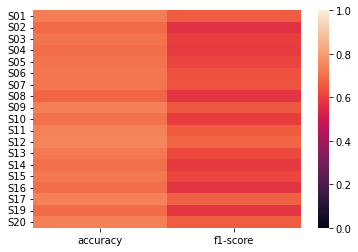

     class0 f1-score  class1 f1-score
S01         0.832061         0.266667
S02         0.815603         0.037037
S03         0.824324         0.071429
S04         0.817891         0.065574
S05         0.823105         0.109091
S06         0.827586         0.166667
S07         0.817869         0.253521
S08         0.802632         0.090909
S09         0.840764         0.193548
S10         0.821656         0.096774
S11         0.842857         0.185185
S12         0.843206         0.307692
S13         0.828283         0.163934
S14         0.818482         0.067797
S15         0.830065         0.133333
S16         0.819355         0.000000
S17         0.838235         0.266667
S19         0.814332         0.065574
S20         0.837838         0.250000


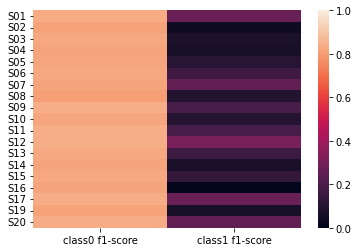

In [9]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [10]:
start=-0.5
step=1.5/(188-1)
timestep_labels=[]
for i in range(input_dim[1]):
    timestep_labels.append(round(start+step*i,3))
    
# timestep_labels

In [11]:
# channel_names=[i for i in range(input_dim[0])]
channel_names=["AFz","F3","F1","Fz","F2","F4","FC5","FC3","FC1","FCz","FC2",
               "FC4","FC6","C5","C3","C1","Cz","C2","C4","C6","CP5","CP3",
               "CP1","CPz","CP2","CP4","CP6","P3","P1","Pz","P2","P4"]

In [66]:
from sklearn.preprocessing import MinMaxScaler

participants_w_list=[]

for i in range(len(participants)):

    w= pickle.load(
        open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-DF_Multivariate-w-e{EPOCH}.pkl", "rb") 
                    )  
    participants_w_list.append(w)
    
avg_w= np.array(participants_w_list).mean(axis=0)
# scaler= MinMaxScaler()
# scaled_avg_w= scaler.fit_transform(avg_w)

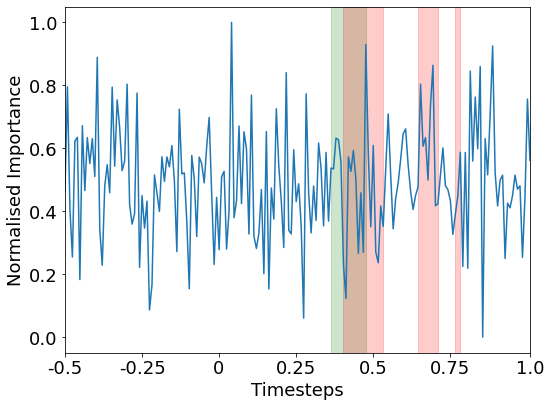

In [67]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler

plt.figure(figsize=(8,6))


scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.sum(0).reshape(-1,1))
df= pd.DataFrame(scaled_avg_w)
# df.index= channel_names
# df.columns=timestep_labels


plt.plot(df)
# plt.legend(methods)
plt.xlabel("Timesteps")
plt.axvspan(107,121, color="green", alpha=0.2)
plt.axvspan(112,128, color="red", alpha=0.2)
plt.axvspan(142,150, color="red", alpha=0.2)
plt.axvspan(157,159, color="red", alpha=0.2)
plt.xticks([0,31,62,93,124,155,187],[-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
plt.ylabel("Normalised Importance")
plt.margins(x=0)
matplotlib.rcParams.update({"font.size":18})
plt.tight_layout()
#     sns.heatmap(df.sum().to_numpy().reshape(-1,1),annot=True, 
#                 yticklabels=timestep_labels, ax=ax[i][1],
#                 xticklabels=False, cbar_kws={"pad":0.02})

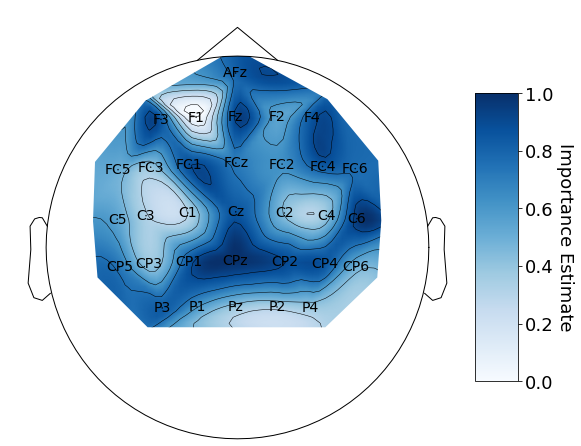

In [68]:
from sklearn.preprocessing import MinMaxScaler
import mne
info= mne.create_info(channel_names, sfreq=500, ch_types=32*["eeg"])
info.set_montage("standard_1020")

fig= plt.figure()
ax= plt.axes((0,0,1.5,1.5))

scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.sum(1).reshape(-1,1))
# df= pd.DataFrame(scaled_avg_w.reshape(-1))

im, _= mne.viz.plot_topomap(
    scaled_avg_w.reshape(-1),
    info,
    ch_type= "eeg",
    sensors=True,
    names=channel_names,
    cmap="Blues",
    axes=ax,
    show=False,
    extrapolate="local"
#     sphere="eeglab"
)
fig.add_axes(ax)
cbar_ax= fig.add_axes([1.3,0.2, 0.1,1])
clb= fig.colorbar(im, cax=cbar_ax)
clb.set_label("Importance Estimate", rotation=270,labelpad=20)

for tt in plt.findobj(fig, matplotlib.text.Text):
    if tt.get_text() in channel_names:
        tt.set_fontsize(14)